# NeuroEvolution of Augmenting Topologies

http://nn.cs.utexas.edu/downloads/papers/stanley.ec02.pdf

In [259]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain
%matplotlib inline

In [398]:
class Gene:
    
    def __init__( self, n1, n2, w ):
        ''' 
            Constructs an instance of a Gene object given,
            n1 : the integer id of the starting node
            n2 : the integer id of the ending node
            w  : a real number describing the weight of the synapse
        '''
        self.innovation = 0
        self.enabled = True
        self.n1 = n1
        self.n2 = n2
        self.w = w
        
    def __str__( self ):
        ''' Returns a string describing the gene. '''
        info = ( self.innovation, self.enabled, self.n1, self.n2, self.w )
        return '[i:%i, e:%s, n1:%i, n2:%i, w:%d]' % info
        
class Genome( list ):
    
    def __init__( self, inputSize, outputSize ):
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.extend([ Gene( i, o, 1 ) 
                     for i in self.inputNodes()
                     for o in self.outputNodes() ])
    
    def nodes( self ):
        ''' Returns the list of nodes encoded in this genome. '''
        n1s = ( g.n1 for g in self )
        n2s = ( g.n2 for g in self )
        io = range( self.numOfIoNodes() )
        return set( n for n in chain( io, n1s, n2s ) )
        
    def inputNodes( self ):
        ''' Returns the input nodes encoded in this genome. '''
        return range( self.inputSize )
    
    def outputNodes( self ):
        ''' Returns the output nodes encoded in this genome. '''
        return range( self.inputSize, 
                      self.inputSize + self.outputSize )
    
    def numOfNodes( self ):
        ''' Returns the number of nodes encoded in genome. '''
        return len( self.nodes() )
    
    def numOfIoNodes( self ):
        ''' Returns the number of IO nodes encoded in the genome. '''
        return self.inputSize + self.outputSize
    
    def numOfHiddenNodes( self ):
        ''' Returns the number of hidden nodes encoded in the genome. '''
        return self.numOfNodes() - self.numOfIoNodes()
    
    def getGene( self, innovation ):
        ''' 
            Returns the gene in the genome with the given innovation,
            if no such gene exists None is returned.
        '''
        try:
            return next(filter( lambda g : g.innovation == innovation, self ))
        except:
            return None
    
    def mutateWeight( self ):
        ''' Randomly changes a weight of a neuron in the genome. '''
        gene = random.choice( self )
        scalar = random.gauss( 1, 0.25 ) # 95% fall in [0.5, 1.5]
        gene.w *= scalar
    
    def mutateAddNode( self ):
        ''' Splits a random neuron into two neurons connected by a new node. '''
        gene = random.choice( self )
        gene.enabled = False
        new = self.numOfNodes()
        g1 = Gene( gene.n1, new, 1.0 )
        g2 = Gene( new, gene.n2, gene.w )
        self.extend([ g1, g2 ])
        return g1, g2
    
    def mutateAddEdge( self ):
        '''  Randomly connects a neuron between two nodes. '''
        hidden = range( self.numOfIoNodes(), self.numOfNodes() )
        ins = chain(range( self.inputSize ), hidden )
        i = random.choice( list(ins) )
        
        alreadyConnected = ( g.n2 if i == g.n1 else g.n1 
                            for g in self if i in (g.n1, g.n2)  )
        outRange = range( self.inputSize, self.numOfNodes() )
        outs = filter( lambda x : x not in alreadyConnected, outRange )
        
        try:
            o = random.choice( list(outs) )
            g = Gene( i, o, 1.0 )
            self.append( g )
            return g
        except IndexError:
            return None
    
    def overlap( self, other ):
        ''' 
            Returns a filter object that iterates across the genes in
            self that share historical markings with the genes in other.
        '''
        otherInnovations = map( lambda g : g.innovation, other )
        return filter( lambda g : g.innovation in otherInnovations, self )
        
    def breedWith( self, other ):
        ''' Creates an offspring genome from two parents. '''
        if self.inputSize != other.inputSize or \
            self.outputSize != other.outputSize:
            return None
        
        child = Genome( self.inputSize, self.outputSize )
        tuples = zip( self.overlap(other), other.overlap(self) )
        child.extend([ random.choice(t) for t in tuples ])
        child.extend([ g for g in self if g not in self.overlap( other ) ])
        child.extend([ g for g in other if g not in other.overlap( self ) ])
        
        return child
    
    def __str__( self ):
        return str([ str(g) for g in self ])
    
def sigmoid( x ):
    return 1 / ( 1 + math.e**-x )
    
class AnnNode:
    
    def __init__( self, nodeId, inputs ):
        ''' 
            Constructs an ANN Node given the unique node id and a
        '''
        self.inputs = inputs
        self.nodeId = nodeId
        
    def evaluate( self, inputVector ):
        ''' Evaluates the output at this node, given an input vector. '''
        if self.nodeId < len( inputVector ):
            return inputVector[ self.nodeId ]
        x = sum( w * n.evaluate(inputVector) for (n, w) in self.inputs )
        return sigmoid(x)
        
class NeuralNetwork:
    
    def __init__( self, genome ):
        self.genome = genome
        outputs = genome.outputNodes()
        self.outputs = [ self.buildNode(o) for o in outputs ]
        
    def buildNode( self, n ):
        ''' Reccursively builds a ANN Node from a node id. '''
        node = AnnNode( n, [] )
        if n in self.genome.inputNodes():
            return node
        
        inputs = filter( 
            lambda gene : gene.enabled and gene.n2 == n, 
            self.genome )
        for gene in inputs:
            i = self.buildNode( gene.n1 )
            node.inputs.append(( i, gene.w ))
            
        return node
    
    def evaluate( self, inputVector ):
        ''' Evaulates the network based on some input vector. '''
        if len( inputVector ) != self.genome.inputSize:
            raise Exception('Incorrect input vector size.')
            
        return [ n.evaluate( inputVector ) for n in self.outputs ]
    
class Population( list ):
    
    def __init__( self, inputSize, outputSize, initialPop ):
        self.inputSize = inputSize
        self.outputSize = outputSize
        
        for i in range( initialPop ):
            innov = 0
            genome = Genome( inputSize, outputSize )
            for gene in genome:
                gene.innovation = innov
                innov += 1
            self.append( genome )
            
    def highestInnovation( self ):
        ''' Returns the highest innovation value present in the population. '''
        if not self:
            return 0
        innovation = lambda g : g.innovation
        return max(chain( *(map(innovation, genome) for genome in self) ))
            
    def getInnovation( self, gene ):
        ''' Returns the innovation that the gene should take. '''
        i = 0
        for genome in self:
            for g in genome:
                if gene != g and (gene.n1, gene.n2) == (g.n1, g.n2):
                    return g.innovation
                i = max( i, g.innovation )
                
        return i + 1
    
    def mutate( self ):
        ''' 
            Picks a random genome in the population to mutate. 
            98% of the time an edge weight mutation occurs,
            1% of the time a connection is added and 1% of the
            time a node is added.
        '''
        genome = random.choice( self )
        
        if random.random() <= 0.98:
            genome.mutateWeight()
        elif random.random() <= 0.7:
            g = genome.mutateAddEdge()
            
            if g != None:
                g.innovation = self.getInnovation( g )
                
        else:
            g1, g2 = genome.mutateAddNode()
            
            g1.innovation = self.getInnovation( g1 )
            g2.innovation = self.getInnovation( g2 )
            
    def speciate( self ):
        ''' 
            Returns a series of lists of genomes organised
            by speciation.
        '''
        return self

In [382]:
def drawGenome( G, title='' ):
    graph = nx.DiGraph()
    for g in G:
        if g.enabled:
            graph.add_edge( g.n1, g.n2, weight=g.w )

    colors = (G.inputSize * ['r']) + \
            (G.outputSize * ['g']) + \
            (G.numOfHiddenNodes() * ['white'])

    pos = nx.spring_layout( graph )
    
    for i in range( G.inputSize ):
        pos[ i ] = [ -2, i / G.inputSize ]
    for i in range( G.inputSize, G.inputSize + G.outputSize ):
        pos[ i ] = [ 2, (i - G.inputSize) / G.outputSize ]

    plt.figure( figsize=(8, 8) )
    nx.draw( graph, pos=pos, node_color=colors, 
            node_size=500, label=title )
    nodes = G.nodes()
    
    labels = dict( (n, str(n)) for n in nodes ) 
    nx.draw_networkx_labels( G, pos, labels, font_size=16 )
    
    edges = graph.edges( data=True )
    edgeLabels = dict(((u, v), '%.2f' % d['weight']) for u, v, d in edges)
    nx.draw_networkx_edge_labels( G, pos, edge_labels = edgeLabels )
    
    plt.show()

In [391]:
P = Population( 3, 2, 2 )
for i in range( 500 ):
    P.mutate()
P.append( P[0].breedWith(P[1]) )

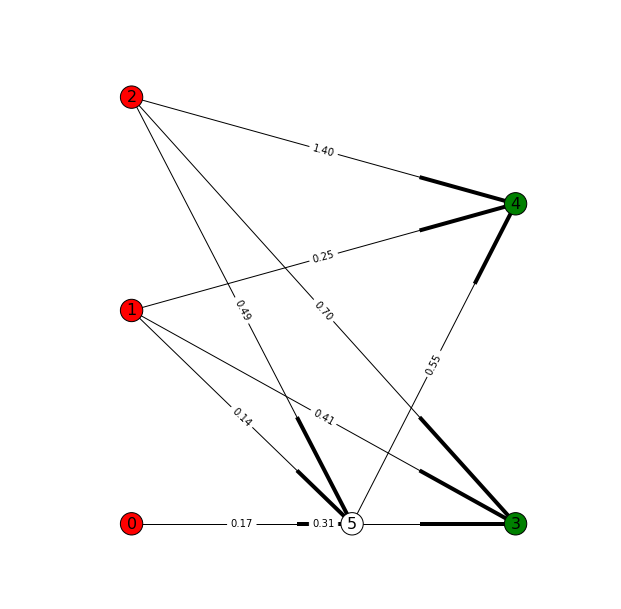

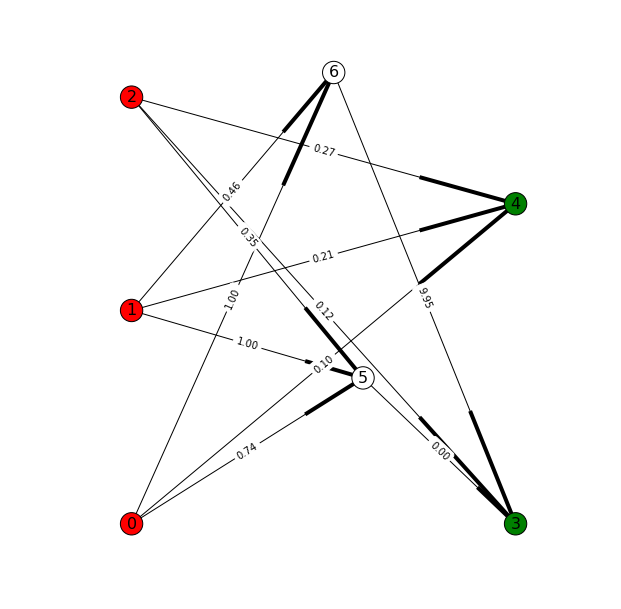

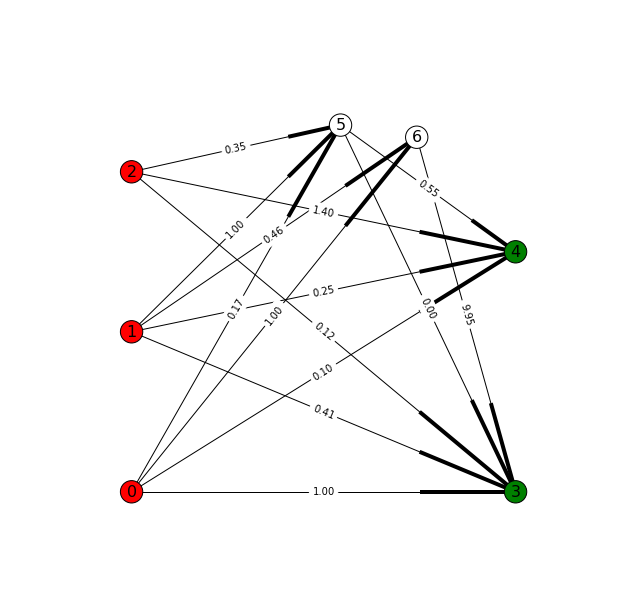

In [392]:
for G in P:
    drawGenome(G)

In [393]:
print('\tG1\t\tG2\t\tchild')
for i in range( P.highestInnovation() + 1 ):
    line = str(i) + '\t'
    for genome in P:
        g = genome.getGene(i)
        if g == None:
            line += '\t\t'
        else:
            data = (g.n1, g.n2, g.w, g.enabled)
            line += '[%i %i %0.3f %i]\t' % data
    print( line )

	G1		G2		child
0	[0 3 0.307 1]	[0 3 4.677 0]	[0 3 1.000 1]	
1	[0 4 0.807 0]	[0 4 0.095 1]	[0 4 0.095 1]	
2	[1 3 0.409 1]	[1 3 0.028 0]	[1 3 0.409 1]	
3	[1 4 0.255 1]	[1 4 0.212 1]	[1 4 0.255 1]	
4	[2 3 0.699 1]	[2 3 0.122 1]	[2 3 0.122 1]	
5	[2 4 1.401 1]	[2 4 0.267 1]	[2 4 1.401 1]	
6	[0 5 0.170 1]	[0 5 0.740 1]	[0 5 0.170 1]	
7			[5 3 0.002 1]	[5 3 0.002 1]	
8			[1 6 0.459 1]	[1 6 0.459 1]	
9			[6 3 9.954 1]	[6 3 9.954 1]	
10	[5 4 0.549 1]			[5 4 0.549 1]	
11	[1 5 0.141 1]	[1 5 1.000 1]	[1 5 0.141 1]	
12	[2 5 0.492 1]	[2 5 0.354 1]	[2 5 0.492 1]	
13			[0 6 1.000 1]	[0 6 1.000 1]	


In [397]:
list(map(str, P[0].overlap(P[1])))

['[i:0, e:True, n1:0, n2:3, w:0]',
 '[i:1, e:False, n1:0, n2:4, w:0]',
 '[i:2, e:True, n1:1, n2:3, w:0]',
 '[i:3, e:True, n1:1, n2:4, w:0]',
 '[i:4, e:True, n1:2, n2:3, w:0]',
 '[i:5, e:True, n1:2, n2:4, w:1]',
 '[i:6, e:True, n1:0, n2:5, w:0]']

Computing using network:  [0.9525744043949467]
Computing using equation:  0.9525744043949467


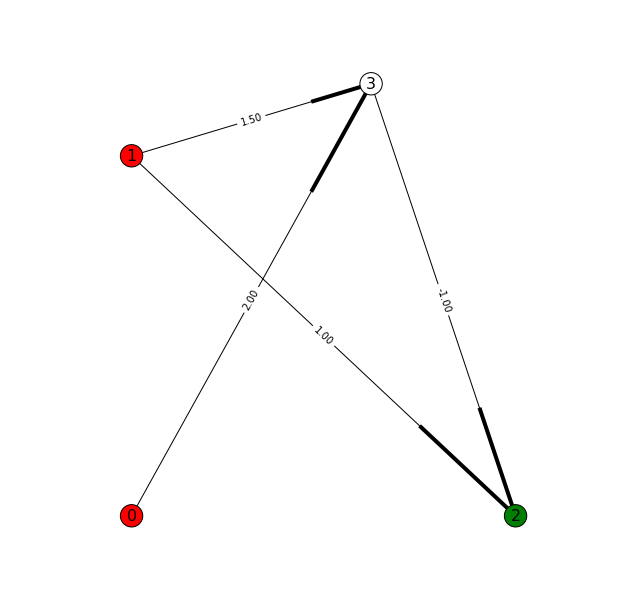

In [378]:
genome = Genome(2, 1)
genome[0].enabled = False
genome.append(Gene( 0, 3, 2 ))
genome.append(Gene( 3, 2, -1 ))
genome.append(Gene( 1, 3, 1.5 ))
net = NeuralNetwork( genome )

print( 'Computing using network: ', net.evaluate([3, 4]) )
print( 'Computing using equation: ', sigmoid(1*4 + -1*sigmoid(1.5*4 + 2*3)) )

drawGenome( genome )